<a href="https://colab.research.google.com/github/anamika1302/CS-541-NER-SARK_NLP/blob/main/NER_Model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Training NER MODEL 1 on enitities :**
# **Duration,Amount,History, Frequency, Method **

In [ ]:
import json

from google.colab import files

license_keys = files.upload()

with open(list(license_keys.keys())[0]) as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)

# Adding license key-value pairs to environment variables
import os
os.environ.update(license_keys)



Saving spark_nlp_for_healthcare_spark_ocr_4700.json to spark_nlp_for_healthcare_spark_ocr_4700.json


In [ ]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.1.2 spark-nlp==$PUBLIC_VERSION

# Installing Spark NLP Display Library for visualization
! pip install -q spark-nlp-display



     |████████████████████████████████| 212.4 MB 73 kB/s 
     |████████████████████████████████| 142 kB 20.8 MB/s 
     |████████████████████████████████| 198 kB 61.7 MB/s 
     |████████████████████████████████| 95 kB 3.3 MB/s 
     |████████████████████████████████| 66 kB 5.0 MB/s 


In [ ]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.1.2 spark-nlp==$PUBLIC_VERSION

# Installing Spark NLP Healthcare
! pip install --upgrade -q spark-nlp-jsl==$JSL_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

# Installing Spark NLP Display Library for visualization
! pip install -q spark-nlp-display

     |████████████████████████████████| 188 kB 11.8 MB/s 


In [ ]:
import sparknlp
import os

spark = sparknlp.start(gpu = True) # for GPU training >> sparknlp.start(gpu = True)

from sparknlp.base import *
from sparknlp.annotator import *

print("Spark NLP version", sparknlp.version())

print("Apache Spark version:", spark.version)

spark



Spark NLP version 3.4.2
Apache Spark version: 3.1.2


In [ ]:

with open('/content/drive/MyDrive/umass_ner/NER_MODEL_1/train_ner_model1.conll') as f:
    train_txt =f.read()

print (train_txt[:500])



-DOCSTART- -X- -X- O

Social NN NN O
History NN NN O
: NN NN O
Tob NN NN O
(-), NN NN O
EtOH NN NN O
- NN NN O
a NNP NNP B-Amount
glass NNP NNP I-Amount
of NN NN O
wine NN NN O
1-2x/month NNP NNP B-Frequency
, NN NN O
IVDU NN NN O
(-), NN NN O
lives NN NN O
with NN NN O
her NN NN O
husband NN NN O
and NN NN O
9yr NN NN O
old NN NN O
daughter NN NN O
, NN NN O
does NN NN O
not NN NN O
work NN NN O
outside NN NN O
of NN NN O
the NN NN O
home NN NN O
. NN NN O

SOCIAL NN NN O
HISTORY NN NN O
: NN N


In [ ]:
from sparknlp.training import CoNLL

training_data = CoNLL().readDataset(spark, '/content/drive/MyDrive/umass_ner/NER_MODEL_1/train_ner_model1.conll')

training_data.show(3)



+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|                 pos|               label|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Social History : ...|[{document, 0, 15...|[{document, 0, 15...|[{token, 0, 5, So...|[{pos, 0, 5, NN, ...|[{named_entity, 0...|
|SOCIAL HISTORY : ...|[{document, 0, 14...|[{document, 0, 14...|[{token, 0, 5, SO...|[{pos, 0, 5, NN, ...|[{named_entity, 0...|
|Social History : ...|[{document, 0, 12...|[{document, 0, 12...|[{token, 0, 5, So...|[{pos, 0, 5, NN, ...|[{named_entity, 0...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows



In [ ]:
training_data.count()

1316

In [ ]:
import pyspark.sql.functions as F

training_data.select(F.explode(F.arrays_zip('token.result', 'pos.result',  'label.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("pos"),
        F.expr("cols['2']").alias("ner_label")).limit(100).show()

+----------+---+-----------+
|     token|pos|  ner_label|
+----------+---+-----------+
|    Social| NN|          O|
|   History| NN|          O|
|         :| NN|          O|
|       Tob| NN|          O|
|      (-),| NN|          O|
|      EtOH| NN|          O|
|         -| NN|          O|
|         a|NNP|   B-Amount|
|     glass|NNP|   I-Amount|
|        of| NN|          O|
|      wine| NN|          O|
|1-2x/month|NNP|B-Frequency|
|         ,| NN|          O|
|      IVDU| NN|          O|
|      (-),| NN|          O|
|     lives| NN|          O|
|      with| NN|          O|
|       her| NN|          O|
|   husband| NN|          O|
|       and| NN|          O|
+----------+---+-----------+
only showing top 20 rows



In [ ]:
training_data.select(F.explode(F.arrays_zip('token.result','label.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("ground_truth")).groupBy('ground_truth').count().orderBy('count', ascending=False).show(100,truncate=False)

+------------+-----+
|ground_truth|count|
+------------+-----+
|O           |63424|
|I-Amount    |1229 |
|I-History   |1218 |
|I-Duration  |1029 |
|B-Amount    |917  |
|B-History   |606  |
|B-Frequency |545  |
|B-Duration  |492  |
|I-Frequency |440  |
|B-Method    |199  |
|I-Method    |15   |
+------------+-----+



In [ ]:
test_data = CoNLL().readDataset(spark, '/content/drive/MyDrive/umass_ner/NER_MODEL_1/test_ner_model1.conll')

test_data.select(F.explode(F.arrays_zip('token.result','label.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("ground_truth")).groupBy('ground_truth').count().orderBy('count', ascending=False).show(100,truncate=False)


+------------+-----+
|ground_truth|count|
+------------+-----+
|O           |3032 |
|I-History   |68   |
|I-Amount    |48   |
|I-Duration  |46   |
|B-Amount    |38   |
|B-History   |37   |
|B-Frequency |25   |
|B-Duration  |18   |
|I-Frequency |17   |
|B-Method    |6    |
+------------+-----+



In [ ]:
import pyspark.sql.functions as F

test_data.select(F.explode(F.arrays_zip('token.result', 'pos.result',  'label.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("pos"),
        F.expr("cols['2']").alias("ner_label")).limit(100).show()

+---------+---+---------+
|    token|pos|ner_label|
+---------+---+---------+
|   SOCIAL| NN|        O|
|  HISTORY| NN|        O|
|        :| NN|        O|
|    Lives| NN|        O|
|     with| NN|        O|
|      his| NN|        O|
|   caring| NN|        O|
|      and| NN|        O|
|  devoted| NN|        O|
|  parents| NN|        O|
|       at| NN|        O|
|     home| NN|        O|
|        .| NN|        O|
|   Enjoys| NN|        O|
|   movies| NN|        O|
|      and| NN|        O|
|computers| NN|        O|
|        .| NN|        O|
|       No| NN|        O|
|  history| NN|        O|
+---------+---+---------+
only showing top 20 rows



In [ ]:
bert_embedding = BertEmbeddings.pretrained('bert_base_cased', 'en')\
   .setInputCols(["sentence",'token'])\
   .setOutputCol("bert_embeddings")\
   .setCaseSensitive(True)

bert_base_cased download started this may take some time.
Approximate size to download 389.1 MB
[OK!]


In [ ]:
# bert_embedding.transform(test_data).write.parquet('/content/drive/MyDrive/umass_ner/NER_MODEL_1/test_data_bert_embedding.parquet')

In [ ]:
# !rm -r /content/drive/MyDrive/umass_ner/NER_MODEL_1/test_data_bert_embedding.parquet

In [ ]:
# !mkdir /root/ner_logs_model1

In [ ]:
# !rm -r /root/ner_logs_model1/

In [ ]:
nerTagger = NerDLApproach()\
      .setInputCols(["sentence", "token", "bert_embeddings"])\
      .setLabelColumn("label")\
      .setOutputCol("ner")\
      .setMaxEpochs(20)\
      .setLr(0.0002)\
      .setBatchSize(16)\
      .setRandomSeed(0)\
      .setVerbose(1)\
      .setEvaluationLogExtended(True) \
      .setEnableOutputLogs(True)\
      .setIncludeConfidence(True)\
      .setUseBestModel(True)\
      .setTestDataset('/content/drive/MyDrive/umass_ner/NER_MODEL_1/test_data_bert_embedding.parquet')\
      .setOutputLogsPath('./ner_dl_logs_model1')# if not set, logs will be written to ~/annotator_logs
 #    .setGraphFolder('graphs') >> put your graph file (pb) under this folder if you are using a custom graph generated thru 4.1 NerDL-Graph.ipynb notebook
 #    .setEnableMemoryOptimizer() >> if you have a limited memory and a large conll file, you can set this True to train batch by batch 
    
# do hyperparameter by tuning the params above (max epoch, LR, dropout etc.) to get better results
ner_pipeline = Pipeline(stages=[
      bert_embedding,
      nerTagger
 ])



In [ ]:
ner_model = ner_pipeline.fit(training_data)

In [ ]:
!cd /root/ner_logs_model1 && ls -lt

/bin/bash: line 0: cd: /root/ner_logs_model1: No such file or directory


In [ ]:
!cat /content/ner_dl_logs_model1/NerDLApproach_23f0b883d940.log

Name of the selected graph: ner-dl/blstm_38_768_128_200.pb
Training started - total epochs: 20 - lr: 2.0E-4 - batch size: 16 - labels: 11 - chars: 89 - training examples: 1316


Epoch 1/20 started, lr: 2.0E-4, dataset size: 1316


Epoch 1/20 - 25.52s - loss: 2787.8171 - batches: 85
Quality on test dataset: 
time to finish evaluation: 1.05s
label	 tp	 fp	 fn	 prec	 rec	 f1
I-Amount	 6	 0	 42	 1.0	 0.125	 0.22222222
B-History	 0	 0	 37	 0.0	 0.0	 0.0
I-History	 15	 9	 53	 0.625	 0.22058824	 0.32608697
B-Frequency	 11	 3	 14	 0.78571427	 0.44	 0.5641026
I-Duration	 1	 1	 45	 0.5	 0.02173913	 0.041666668
B-Method	 0	 0	 6	 0.0	 0.0	 0.0
I-Frequency	 8	 0	 9	 1.0	 0.47058824	 0.64
B-Duration	 1	 0	 17	 1.0	 0.055555556	 0.10526316
B-Amount	 7	 1	 31	 0.875	 0.18421052	 0.3043478
tp: 49 fp: 14 fn: 254 labels: 9
Macro-average	 prec: 0.64285713, rec: 0.1686313, f1: 0.26717776
Micro-average	 prec: 0.7777778, rec: 0.16171618, f1: 0.2677596


Epoch 2/20 started, lr: 1.9900496E-4, dataset size: 13

In [ ]:
pred_df = ner_model.stages[1].transform(bert_embedding.transform(test_data))
# pred_df = ner_model.stages[1].transform(test_data)

In [ ]:
import pyspark.sql.functions as F

pred_df.select(F.explode(F.arrays_zip(pred_df.token.result,
                                          pred_df.label.result,
                                          pred_df.ner.result)).alias("cols")) \
                              .select(F.expr("cols['0']").alias("token"),
                                      F.expr("cols['1']").alias("ground_truth"),
                                      F.expr("cols['2']").alias("prediction")).toPandas()

,token,ground_truth,prediction
0,SOCIAL,O,O
1,HISTORY,O,O
2,:,O,O
3,Lives,O,O
4,with,O,O
...,...,...,...
3330,She,O,O
3331,is,O,O
3332,Spanish,O,O
3333,speaking,O,O


In [ ]:


import pyspark.sql.functions as F

pred_df.select(F.explode(F.arrays_zip(pred_df.token.result,
                                          pred_df.label.result,
                                          pred_df.ner.result)).alias("cols")) \
                              .select(F.expr("cols['0']").alias("token"),
                                      F.expr("cols['1']").alias("ground_truth"),
                                      F.expr("cols['2']").alias("prediction")).show(truncate=False)



+---------+------------+----------+
|token    |ground_truth|prediction|
+---------+------------+----------+
|SOCIAL   |O           |O         |
|HISTORY  |O           |O         |
|:        |O           |O         |
|Lives    |O           |O         |
|with     |O           |O         |
|his      |O           |O         |
|caring   |O           |O         |
|and      |O           |O         |
|devoted  |O           |O         |
|parents  |O           |O         |
|at       |O           |O         |
|home     |O           |O         |
|.        |O           |O         |
|Enjoys   |O           |O         |
|movies   |O           |O         |
|and      |O           |O         |
|computers|O           |O         |
|.        |O           |O         |
|No       |O           |O         |
|history  |O           |O         |
+---------+------------+----------+
only showing top 20 rows



In [ ]:
from sklearn.metrics import classification_report

preds_df_analysis = pred_df.select(F.explode(F.arrays_zip(pred_df.token.result,
                                                     pred_df.label.result,
                                                     pred_df.ner.result)).alias("cols")) \
                      .select(F.expr("cols['0']").alias("token"),
                              F.expr("cols['1']").alias("ground_truth"),
                              F.expr("cols['2']").alias("prediction")).toPandas()

print (classification_report(preds_df_analysis['ground_truth'], preds_df_analysis['prediction']))



              precision    recall  f1-score   support

    B-Amount       0.78      0.92      0.84        38
  B-Duration       0.64      0.78      0.70        18
 B-Frequency       0.83      0.96      0.89        25
   B-History       0.71      0.78      0.74        37
    B-Method       0.75      0.50      0.60         6
    I-Amount       0.78      0.94      0.85        48
  I-Duration       0.69      0.74      0.72        46
 I-Frequency       0.77      1.00      0.87        17
   I-History       0.69      0.81      0.74        68
           O       0.99      0.98      0.98      3032

    accuracy                           0.96      3335
   macro avg       0.76      0.84      0.79      3335
weighted avg       0.97      0.96      0.97      3335



In [ ]:
ner_model.stages[1].write().overwrite().save('/content/drive/MyDrive/umass_ner/model_ner_dl_1')

In [ ]:
!wget  -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/utils/conll_eval.py

import conll_eval

metrics = conll_eval.evaluate(preds_df_analysis['ground_truth'].values, preds_df_analysis['prediction'].values)


import pandas as pd
pd.DataFrame(metrics[1], columns=['entity','precision','recall','f1','support'])



processed 3335 tokens with 124 phrases; found: 147 phrases; correct: 100.
accuracy:  84.49%; (non-O)
accuracy:  96.43%; precision:  68.03%; recall:  80.65%; FB1:  73.80
           Amount: precision:  68.75%; recall:  86.84%; FB1:  76.74  48
         Duration: precision:  56.52%; recall:  72.22%; FB1:  63.41  23
        Frequency: precision:  82.76%; recall:  96.00%; FB1:  88.89  29
          History: precision:  62.79%; recall:  72.97%; FB1:  67.50  43
           Method: precision:  75.00%; recall:  50.00%; FB1:  60.00  4


,entity,precision,recall,f1,support
0,Amount,68.750000,86.842105,76.744186,48
1,Duration,56.521739,72.222222,63.414634,23
2,Frequency,82.758621,96.000000,88.888889,29
3,History,62.790698,72.972973,67.500000,43
4,Method,75.000000,50.000000,60.000000,4


In [ ]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/utils/ner_log_parser.py


In [ ]:
import ner_log_parser



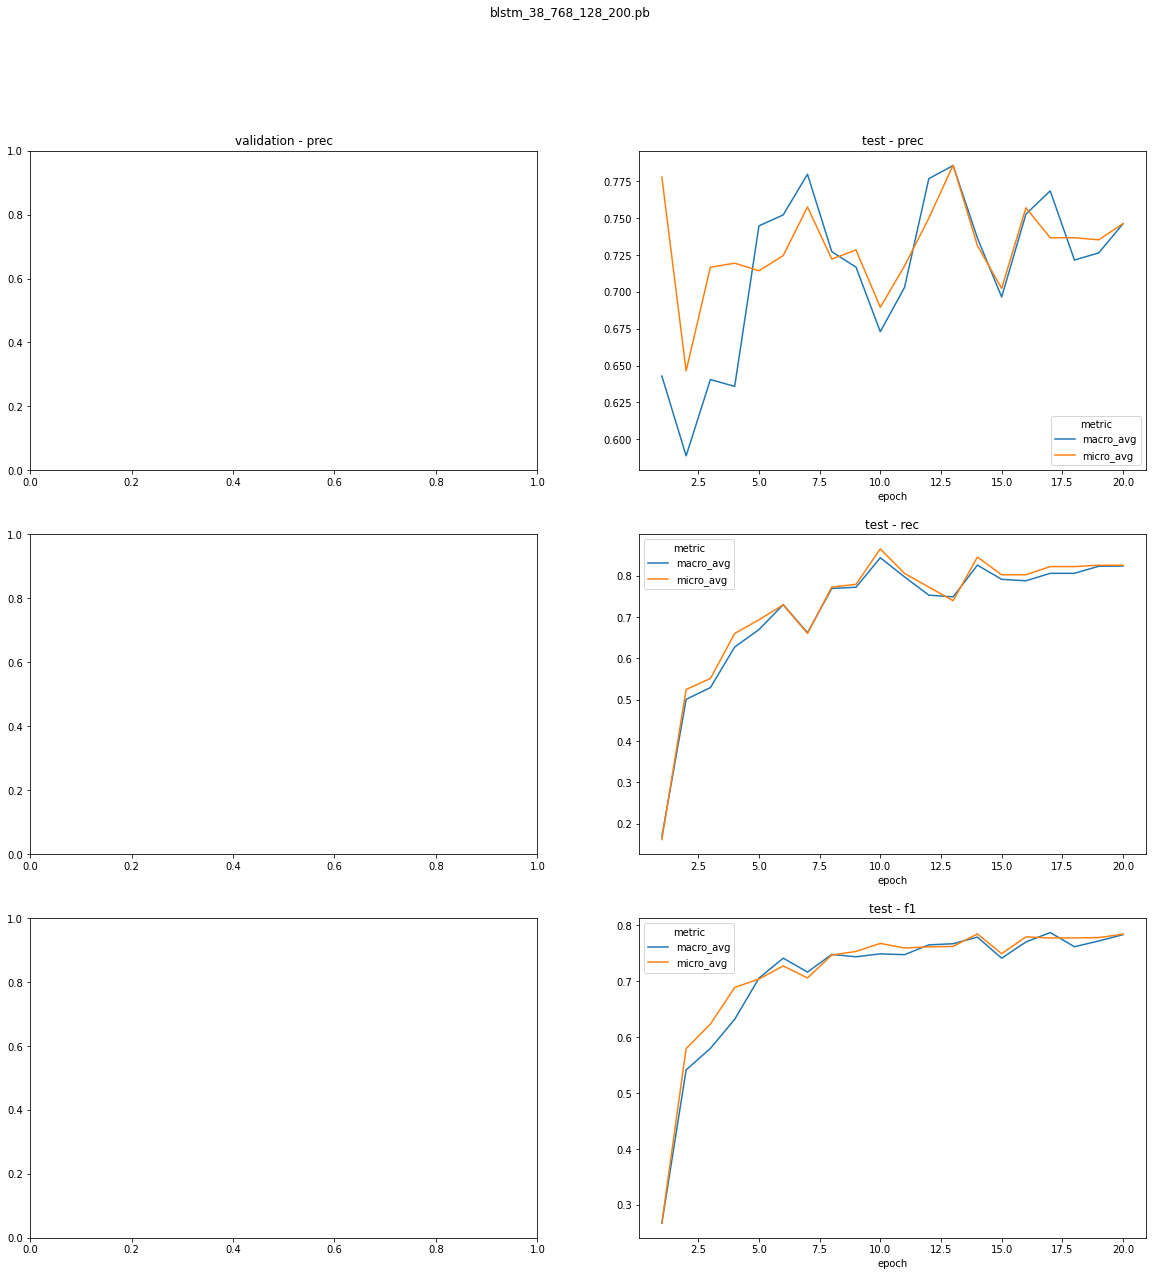

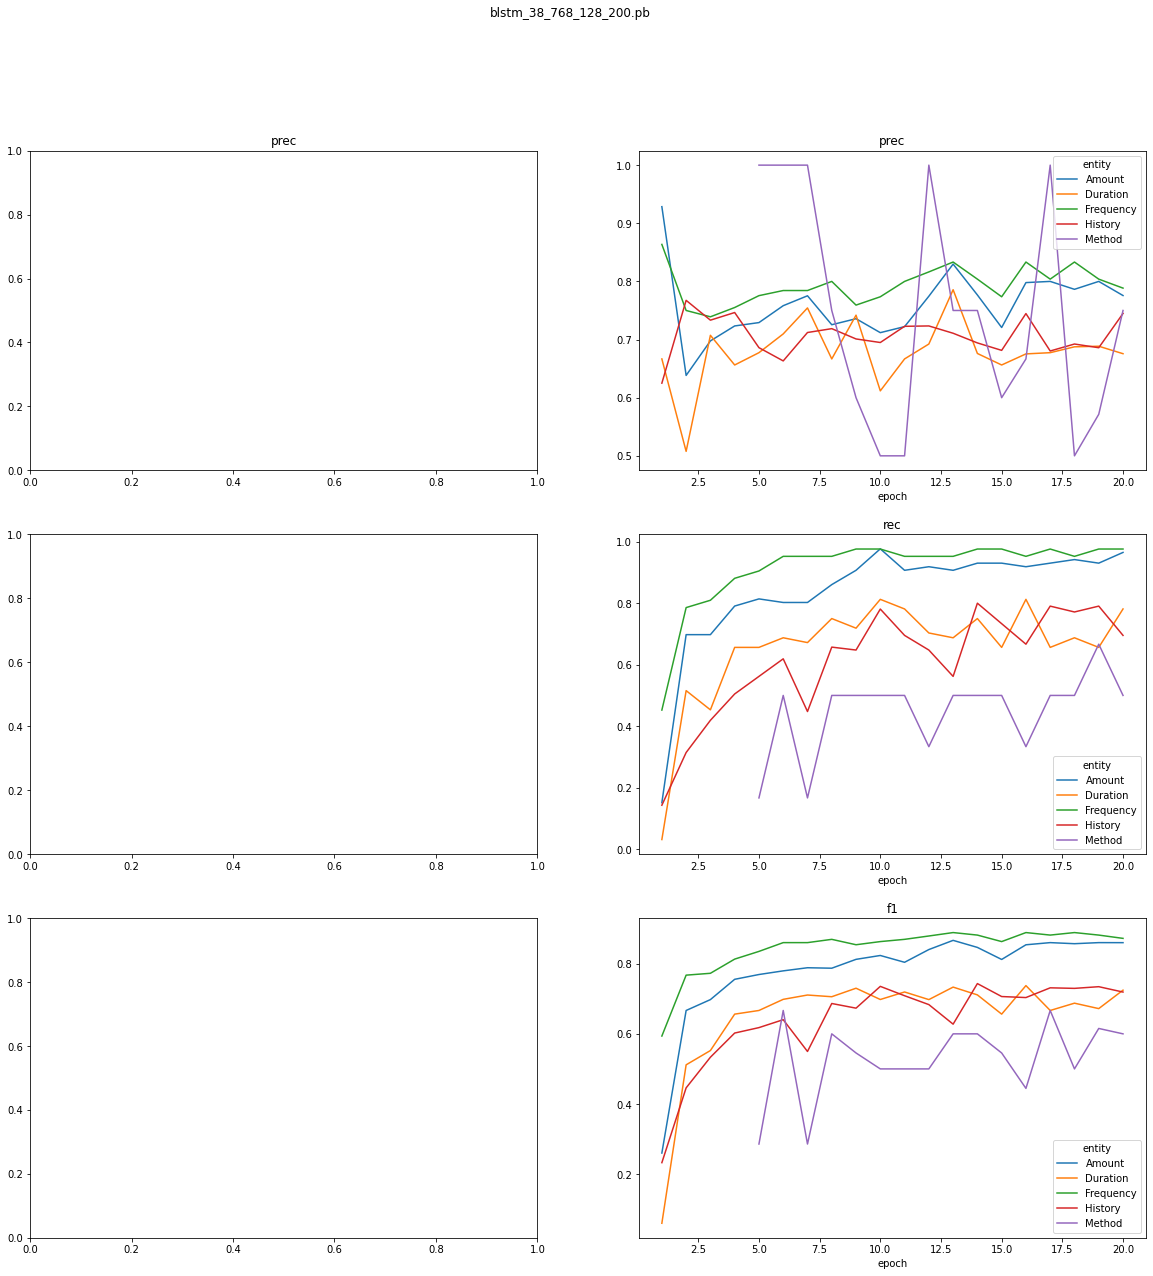

In [ ]:
ner_log_parser.get_charts('/content/ner_dl_logs_model1/NerDLApproach_23f0b883d940.log')

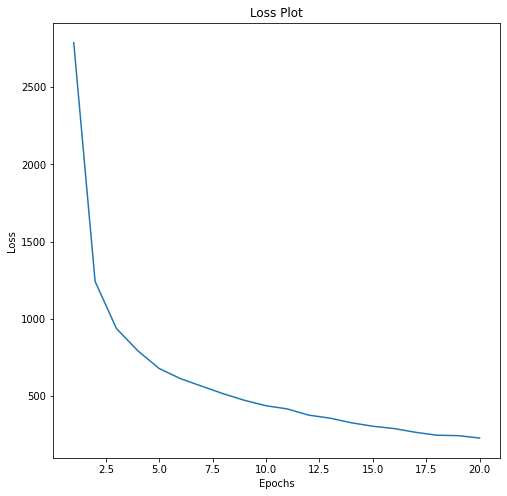

In [ ]:
ner_log_parser.loss_plot('/content/ner_dl_logs_model1/NerDLApproach_23f0b883d940.log')

In [ ]:


document = DocumentAssembler()\
        .setInputCol("text")\
        .setOutputCol("document")

sentence = SentenceDetector()\
        .setInputCols(['document'])\
        .setOutputCol('sentence')

token = Tokenizer()\
        .setInputCols(['sentence'])\
        .setOutputCol('token')

bert_embedding = BertEmbeddings.pretrained('bert_base_cased', 'en')\
   .setInputCols(["sentence",'token'])\
   .setOutputCol("bert_embeddings")\
   .setCaseSensitive(True)
  
# load trained model
loaded_ner_model = NerDLModel.load("/content/drive/MyDrive/umass_ner/model_ner_dl_1")\
        .setInputCols(["sentence", "token", "bert_embeddings"])\
        .setOutputCol("ner")

converter = NerConverter()\
        .setInputCols(["document", "token", "ner"])\
        .setOutputCol("ner_span")

ner_prediction_pipeline = Pipeline(stages = [
        document,
        sentence,
        token,
        bert_embedding,
        loaded_ner_model,
        converter
])



bert_base_cased download started this may take some time.
Approximate size to download 389.1 MB
[OK!]


In [ ]:


empty_data = spark.createDataFrame([['']]).toDF("text")

prediction_model = ner_prediction_pipeline.fit(empty_data)



In [ ]:
pred_df_new = prediction_model.transform(test_data)

In [ ]:


from sparknlp.base import LightPipeline

light_model = LightPipeline(prediction_model)



In [ ]:
text = """Social History:
Works as a corrections officer. Lived alone, but moved in with
his brother after his cirrhosis diagnosis. Never smoker. Last
drink 40 days ago per patient report. Prior to diagnosis of
cirrhosis drank >8 "mixed drinks" per day. Started drinking at
age 18. Denies any current or prior IVDU or other street drugs,
although does have h/o marijuana use many years ago. Is
concerned about work and disability benefits, as supposedly his
disability and life insurance policies do not cover alcoholic
cirrhosis. Never married, has 21 year old daughter who is a part
of his life. Denies any h/o alcohol withdrawal symptoms or
seizures"""

In [ ]:


import pandas as pd

result = light_model.fullAnnotate(text)

ner_df= pd.DataFrame([(int(x.metadata['sentence']), x.result, x.begin, x.end, y.result) for x,y in zip(result[0]["token"], result[0]["ner"])], 
                      columns=['sent_id','token','start','end','ner'])
ner_df



,sent_id,token,start,end,ner
0,0,Social,0,5,O
1,0,History,7,13,O
2,0,:,14,14,O
3,0,Works,16,20,O
4,0,as,22,23,O
...,...,...,...,...,...
117,9,alcohol,603,609,O
118,9,withdrawal,611,620,O
119,9,symptoms,622,629,O
120,9,or,631,632,O


In [ ]:
from sparknlp_display import NerVisualizer

visualiser = NerVisualizer()

visualiser.display(result[0], label_col='ner_span', document_col='document', save_path="display_result.html")